# Geodesic Hamiltonian Monte Carlo (GHMC)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import vonmises
from tqdm import tqdm
import pandas as pd

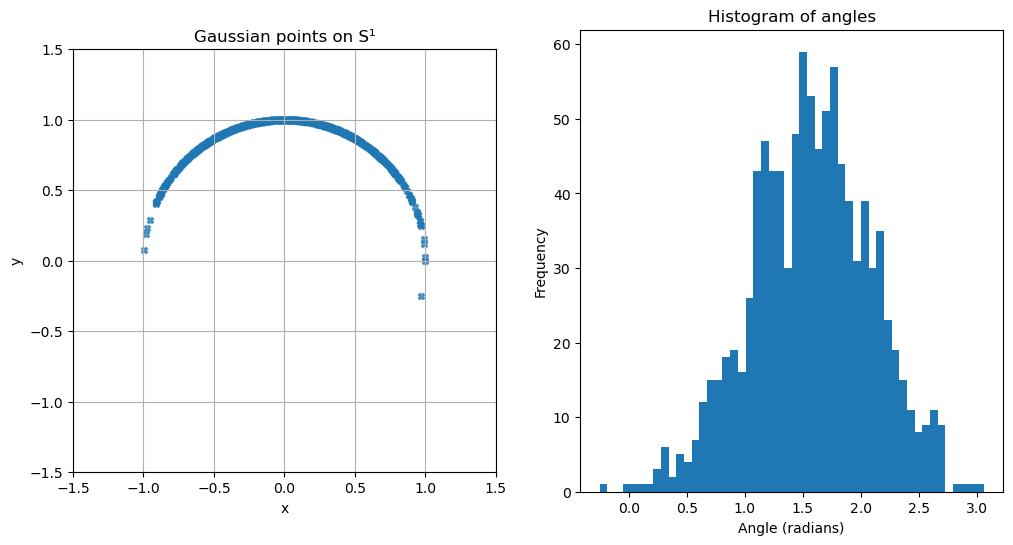

In [2]:
def generate_points_on_circle(n_samples, mu=np.pi/2, sigma=0.5):
    angles = np.random.normal(loc=mu, scale=sigma, size = n_samples)
    angles = np.mod(angles +np.pi, 2 * np.pi) - np.pi  # map to [-π, π]

    # Map to unit circle
    x = np.cos(angles)
    y = np.sin(angles)
    circle_points = np.stack((x, y), axis=1)

    return circle_points, angles

# Generate and plot
circle_points, angles_observed = generate_points_on_circle(n_samples=1000)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(circle_points[:, 0], circle_points[:, 1], s=20, alpha=0.7,marker="X")
plt.gca().set_aspect('equal')
plt.title("Gaussian points on S¹")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.grid(True)

plt.subplot(122)
plt.hist(angles_observed,bins = 50)
plt.title("Histogram of angles")
plt.xlabel("Angle (radians)")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()


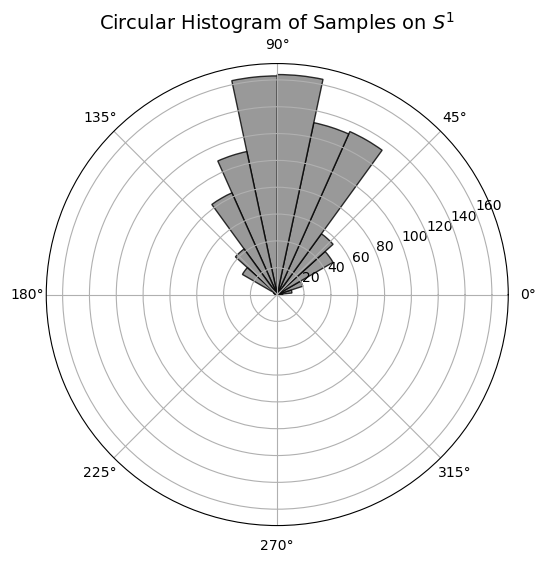

In [3]:
# 
angles = np.arctan2(circle_points[:,1], circle_points[:,0])  # valores en [-π, π]
angles = (angles) % (2 * np.pi)  # valores en [0, 2π] para el histograma

# 
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))

# 
n_bins = 30
counts, bins = np.histogram(angles, bins=n_bins, range=(0, 2*np.pi))
width = (2 * np.pi) / n_bins
bars = ax.bar(bins[:-1], counts, width=width, color='gray', edgecolor='black', alpha=0.8)

# Opciones del gráfico
ax.set_theta_zero_location("E")  
ax.set_theta_direction(1)    
ax.set_title("Circular Histogram of Samples on $S^1$", fontsize=14)

plt.show()

Potential energy: 2.0119601678624592
Gradient of potential energy: [ 2.01196017 -1.75048597]


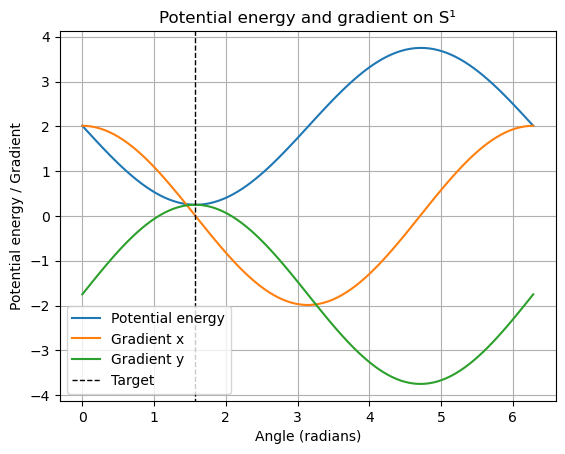

In [4]:
# 2. Log-likelihood for the mixture on S¹
def U(theta):
    theta1, theta2 = theta
    tol  = 1E-1
    log_prior = 0 if abs(theta1**2 + theta2**2 - 1) < tol else 1E4
    log_lik = np.mean([np.linalg.norm(theta - point)**2 for point in circle_points])
    return log_prior + log_lik
    
    

# 3. Gradient of the log-likelihood (numerical, for simplicity)
def gradient_U(theta, eps=1e-5):
    theta1, theta2 = theta
    grad = np.zeros(2)
    grad[0] = (U([theta1 + eps, theta2]) - U([theta1 - eps, theta2])) / (2 * eps)
    grad[1] = (U([theta1, theta2 + eps]) - U([theta1, theta2 - eps])) / (2 * eps)
    return grad


print("Potential energy:", U([1.0, 0.0]))
print("Gradient of potential energy:", gradient_U([1.0, 0.0]))

plt.plot(np.linspace(0, 2*np.pi, 100),[U([np.cos(a),np.sin(a)]) for a in np.linspace(0, 2*np.pi, 100)])
plt.plot(np.linspace(0, 2*np.pi, 100),[gradient_U([np.cos(a),np.sin(a)])[0] for a in np.linspace(0, 2*np.pi, 100)])
plt.plot(np.linspace(0, 2*np.pi, 100),[gradient_U([np.cos(a),np.sin(a)])[1] for a in np.linspace(0, 2*np.pi, 100)])
plt.axvline(np.pi/2, -2, 10, color='black', lw=1, ls='--')
plt.title("Potential energy and gradient on S¹")
plt.xlabel("Angle (radians)")
plt.ylabel("Potential energy / Gradient")
plt.legend(["Potential energy", "Gradient x", "Gradient y", "Target"])
plt.grid(True)
plt.show()

In [5]:
def project_to_tangent_space(theta, phi):
    return phi - np.dot(phi, theta) * theta


def geodesic_flow(theta, phi, step_size):
    alpha = np.linalg.norm(phi)
    if alpha > 1e-10:
        new_theta = theta * np.cos(alpha * step_size) + (phi / alpha) * np.sin(alpha * step_size)
        new_phi = phi * np.cos(alpha * step_size) - alpha * theta * np.sin(alpha * step_size)
    else:
        new_theta, new_phi = theta, phi 
    return new_theta, new_phi



def GHMC(n_iter=1000, step_size=0.1, L=10, initial_theta=[0.0, 0.0]):
    # Embedding dimension (S¹ ⊂ ℝ²)
    theta = np.array(initial_theta)
    theta_history = [np.array(initial_theta)]
    hamiltonian_history = [U(theta_history[-1])]

    acceptance_rate = 0.0   
    
    for _ in tqdm(range(n_iter)):

        theta = theta_history[-1].copy() 

        # 1. Sample momentum φ (in the tangent space)
        phi = np.random.normal(0, 1, size=len(theta))
        phi = project_to_tangent_space(theta, phi)  # Project to tangent space
        current_phi = phi.copy()

        # 3. Leapfrog integrator
        for _ in range(L):
            # Half step for φ
            grad = gradient_U(theta)
            phi -= 0.5 * step_size * grad
            phi = project_to_tangent_space(theta, phi) 

            # Geodesic flow in S¹ (update θ and φ)
            theta, phi = geodesic_flow(theta, phi, step_size)
        
            # Other half step for φ
            grad = gradient_U(theta)
            phi -= 0.5 * step_size * grad
        
        # 4. Aceptance/rejection (Metropolis-Hastings)
        current_H = U(theta_history[-1]) + np.dot(current_phi, current_phi) / 2
        proposed_H = U(theta) + np.dot(phi, phi) / 2
        log_accept_prob =  current_H - proposed_H
        
        if np.log(np.random.rand()) < log_accept_prob:
            theta_history.append(theta)  # Accept the new sample
            hamiltonian_history.append(U(theta))
            acceptance_rate += 1.0 / n_iter
        else:
            theta_history.append(theta_history[-1])  # Reject the new sample, keep the old one
            hamiltonian_history.append(hamiltonian_history[-1])
        
    
    return np.array(theta_history), np.array(hamiltonian_history), acceptance_rate


In [6]:
# Execute the GHMC algorithm
theta_history, hamiltonian_history, acceptance_rate = GHMC(n_iter=2500, step_size=0.1, L=10, initial_theta=[-np.cos(np.pi/3),np.sin(np.pi/3)])

print(f"Acceptance rate: {acceptance_rate}")

100%|██████████| 2500/2500 [35:43<00:00,  1.17it/s] 

Acceptance rate: 0.8679999999999697


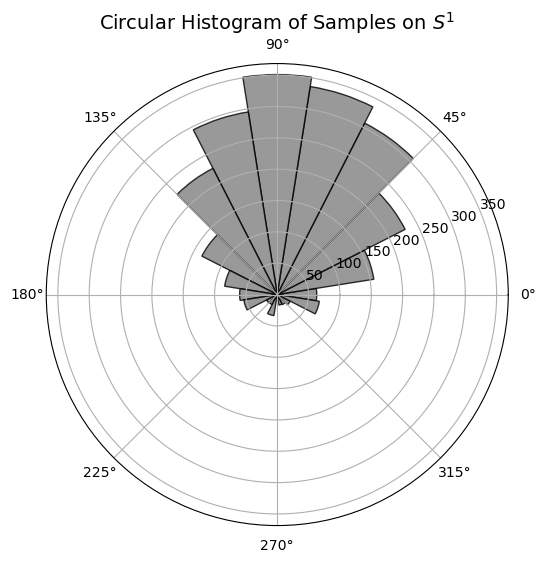

In [7]:
# 
angles = np.arctan2(theta_history[:,1], theta_history[:,0])  # valores en [-π, π]
angles = (angles) % (2 * np.pi)  # valores en [0, 2π] para el histograma

# 
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))

# 
n_bins = 20
counts, bins = np.histogram(angles, bins=n_bins, range=(0, 2*np.pi))
width = (2 * np.pi) / n_bins
bars = ax.bar(bins[:-1], counts, width=width, color='gray', edgecolor='black', alpha=0.8)

# Opciones del gráfico
ax.set_theta_zero_location("E")  
ax.set_theta_direction(1)    
ax.set_title("Circular Histogram of Samples on $S^1$", fontsize=14)

plt.show()

c:\Users\carlo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\carlo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\carlo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


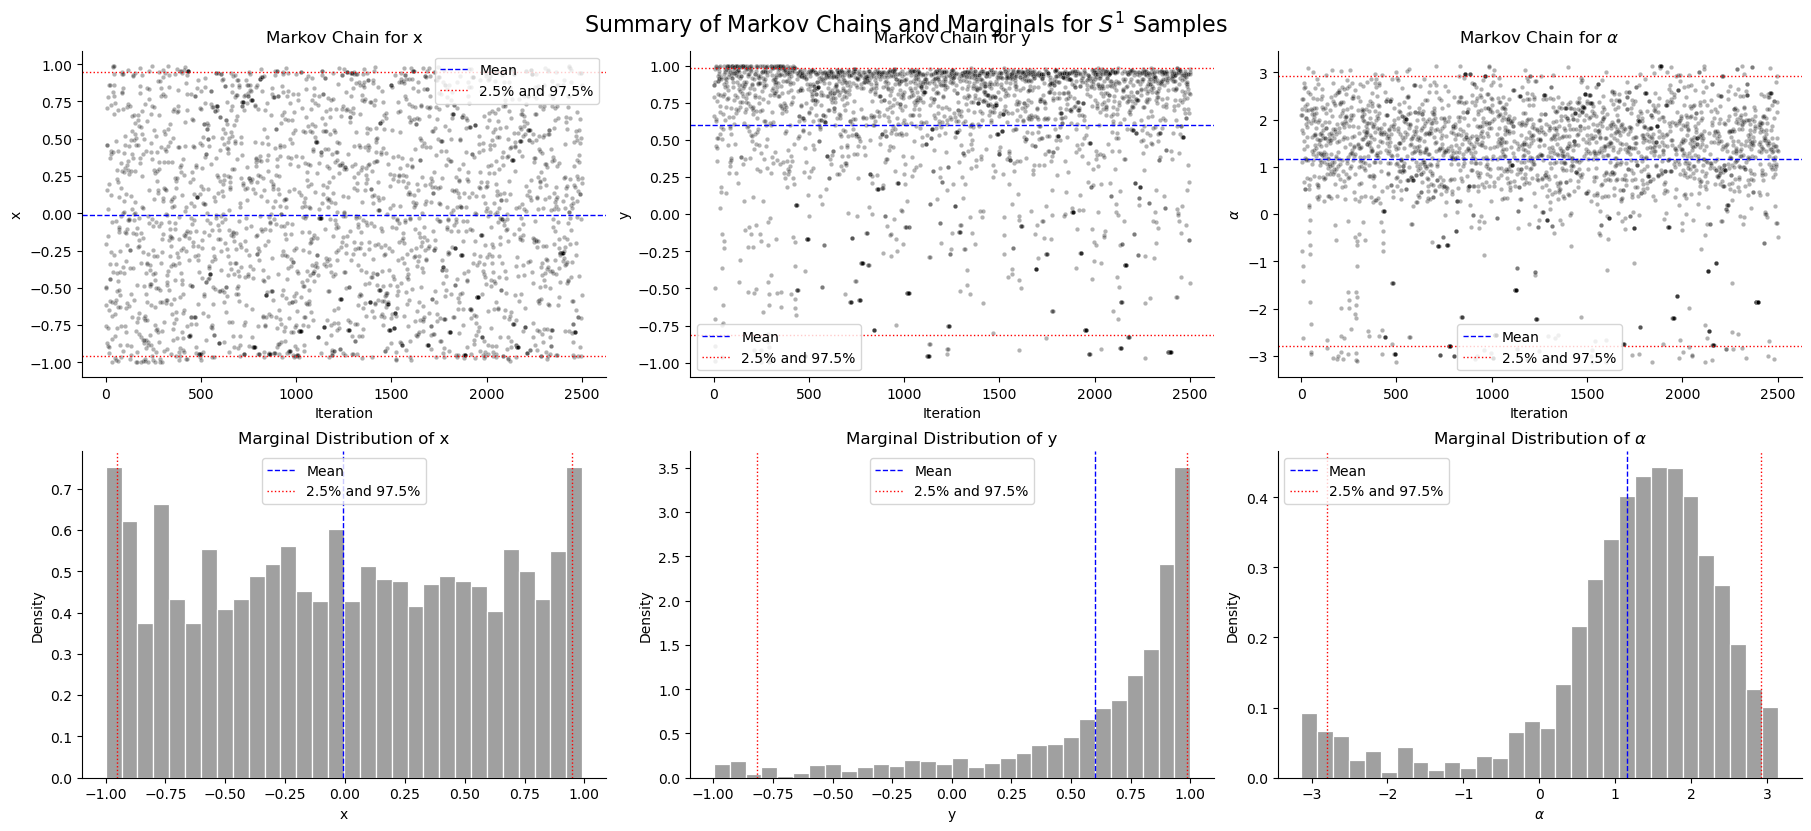

In [8]:
#
angles = np.arctan2(theta_history[:,1], theta_history[:,0])

components = {
    'x': theta_history[:,0],
    'y': theta_history[:,1],
    r'$\alpha$': angles
}

iterations = np.arange(1, len(angles) + 1)

fig, axes = plt.subplots(2, 3, figsize=(18, 8), constrained_layout=True)

for i, (label, data) in enumerate(components.items()):
    # -------- Primera fila: cadenas de Markov --------
    mean_val = np.mean(data)
    quantiles = np.quantile(data, [0.025, 0.975])

    sns.scatterplot(x=iterations, y=data, color='black', alpha=0.3, s=10, ax=axes[0, i])
    axes[0, i].axhline(mean_val, color='blue', linestyle='--', linewidth=1, label='Mean')
    axes[0, i].axhline(quantiles[0], color='red', linestyle=':', linewidth=1, label='2.5% and 97.5%')
    axes[0, i].axhline(quantiles[1], color='red', linestyle=':', linewidth=1)

    axes[0, i].set_xlabel("Iteration")
    axes[0, i].set_ylabel(label)
    axes[0, i].set_title(f"Markov Chain for {label}")
    axes[0, i].legend()
    sns.despine(ax=axes[0, i])

    # -------- Segunda fila: histogramas --------
    sns.histplot(data, bins=30, kde=False, stat='density', color='gray', edgecolor='white', ax=axes[1, i])
    axes[1, i].axvline(mean_val, color='blue', linestyle='--', linewidth=1, label='Mean')
    axes[1, i].axvline(quantiles[0], color='red', linestyle=':', linewidth=1, label='2.5% and 97.5%')
    axes[1, i].axvline(quantiles[1], color='red', linestyle=':', linewidth=1)

    axes[1, i].set_xlabel(label)
    axes[1, i].set_ylabel("Density")
    axes[1, i].set_title(f"Marginal Distribution of {label}")
    axes[1, i].legend()
    sns.despine(ax=axes[1, i])

plt.suptitle("Summary of Markov Chains and Marginals for $S^1$ Samples", fontsize=16, y=1.02)
plt.show()

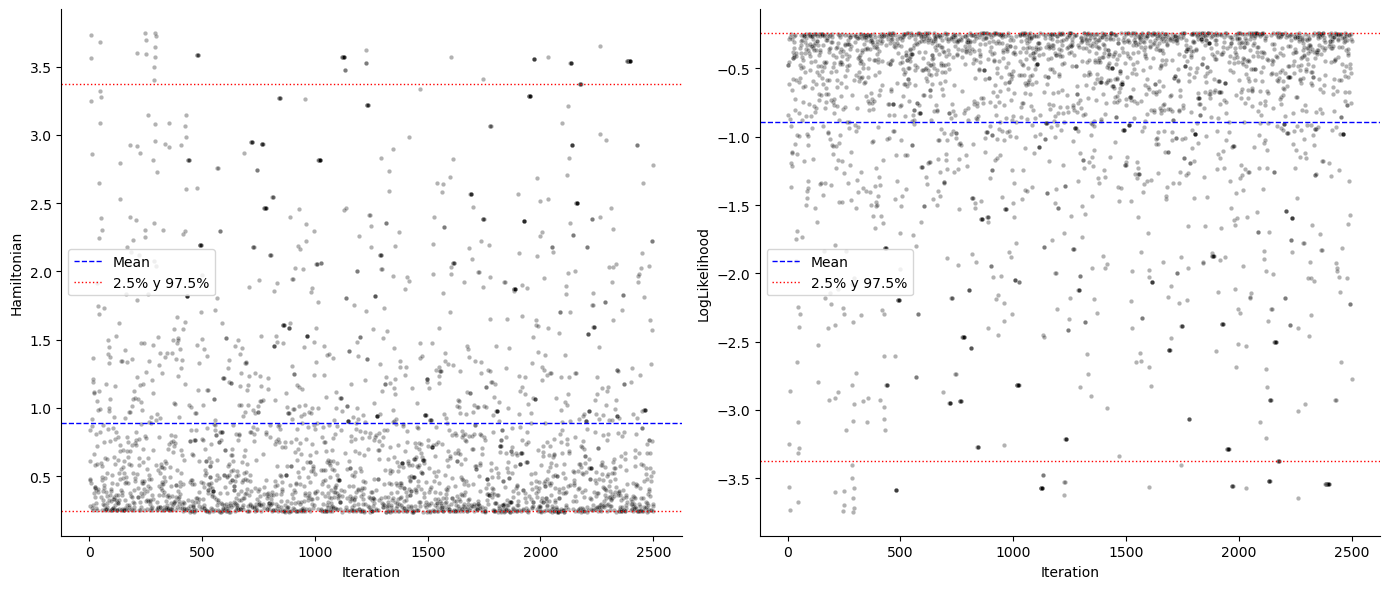

In [9]:
# 
x1 = hamiltonian_history
iterations1 = np.arange(1, len(x1) + 1)
data1 = pd.DataFrame({
    'Iteration': iterations1,
    'LogLikelihood': x1
})
mean1 = np.mean(x1)
quantiles1 = np.quantile(x1, [0.025, 0.975])

# 
x2 = [np.mean([-np.linalg.norm(theta - point)**2 for point in circle_points]) for theta in theta_history]
iterations2 = np.arange(1, len(x2) + 1)
data2 = pd.DataFrame({
    'Iteration': iterations2,
    'LogLikelihood': x2
})
mean2 = np.mean(x2)
quantiles2 = np.quantile(x2, [0.025, 0.975])

#
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 fila, 2 columnas

# 
sns.scatterplot(ax=axs[0], x='Iteration', y='LogLikelihood', data=data1, color='black', alpha=0.3, s=10)
axs[0].axhline(mean1, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[0].axhline(quantiles1[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[0].axhline(quantiles1[1], color='red', linestyle=':', linewidth=1)
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Hamiltonian")
axs[0].legend()


#
sns.scatterplot(ax=axs[1], x='Iteration', y='LogLikelihood', data=data2, color='black', alpha=0.3, s=10)
axs[1].axhline(mean2, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[1].axhline(quantiles2[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[1].axhline(quantiles2[1], color='red', linestyle=':', linewidth=1)
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("LogLikelihood")
axs[1].legend()

sns.despine()
plt.tight_layout()
plt.show()
